In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os,sys,glob
from math import *
import xarray as xr

# Load own modules
projectname = 'EUREC4A_organization'
workdir = os.getcwd()
rootdir = os.path.dirname(workdir)
while os.path.basename(rootdir) != projectname:
    rootdir = os.path.dirname(rootdir)
repodir = rootdir
moduledir = os.path.join(repodir,'functions')
resultdir = os.path.join(repodir,'results','analytical_models')
figdir = os.path.join(repodir,'figures','analytical_models')
inputdir = '/Users/bfildier/Dropbox/Data/EUREC4A/sondes_radiative_profiles/'
scriptsubdir = 'step_function_RH'

# current environment
thismodule = sys.modules[__name__]

##-- Own modules
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

#- Parameters & constants
from thermoConstants import *
from matrixoperators import *
from radiativefeatures import *
from radiativescaling import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats', 'thermoConstants', 'radiativescaling', 'radiativefeatures', 'matrixoperators']


# Implement idealized model

In [2]:
class IdealizedProfiles():
    
    def __init__(self,pres,\
                    kappa_rot = 127,\
                    nu_rot = 150,\
                    l_rot = 56):
        """Constructor -- initalize pressure coordinate.
        
        Arguments:
        - p_values: reference pressure array (hPa)
        - kappa_rot, default = 127 # m2/kg
        - nu_rot, default = 150 # cm-1
        - l_rot, default = 56 # cm-1"""
        
        self.pres = pres
        self.kappa_rot = kappa_rot
        self.nu_rot = nu_rot
        self.l_rot = l_rot
                 
        return
    
    
    def initRH(self,pres_jump,rh_max,rh_min):
        """Generate an RH profile as a step function

        Arguments:
        - pres_jump: level of RH jump (hPa)
        - rh_max: lower-tropospheric RH
        - rh_min: upper-tropospheric RH
        """    

        # store input parameters
        self.pres_jump = pres_jump
        self.rh_max = rh_max
        self.rh_min = rh_min
        
        # init
        rh_values = np.full(self.pres.shape,np.nan)
        # masks
        lowert = self.pres >= pres_jump
        uppert = self.pres < pres_jump
        # assign
        rh_values[uppert] = rh_min
        rh_values[lowert] = rh_max

        self.rh = rh_values
    
    def computePowerExponent(self,temp):
        """Approximation of exponent alpha

        Arguments:
        - temp: (K)"""

        Gamma = 6.5e-3 # K/m   

        self.alpha = L_v*Gamma/temp/gg*R_d/R_v - 1

    def computeQV(self,qvstar_surf,i_surf=-1):
        """Idealized qv_star profile as a power function of pressure

        Arguments:
        - qvstar_surf: surface saturated specific humidity (kg/kg)
        - i_surf: index of surface layer in array (default is -1, last element)"""

        self.qvstar_surf = qvstar_surf
        # qv_star
        self.qvstar =  qvstar_surf*np.power((self.pres/self.pres[-1]),self.alpha)
        # qv
        self.qv = self.rh * self.qvstar

    def computeWaterPath(self,i_surf=-1):
        """Water path from top of atmosphere, in mm

        Arguments:
        - i_surf: index of surface layer in array (default is -1, last element)
        """

        hPa_to_Pa = 100
        rho_w = 1e3 # kg/m3
        m_to_mm = 1e3

        # init
        W = np.full(self.pres.shape,np.nan)
        # constant
        A = self.qvstar_surf/(self.pres[i_surf]*hPa_to_Pa)**self.alpha/gg/(1+self.alpha)
        print(A)
        # lower troposphere
        lowert = self.pres >= self.pres_jump
        W[lowert] = A*(self.rh_max*(self.pres[lowert]*hPa_to_Pa)**(self.alpha+1)-\
                       (self.rh_max-self.rh_min)*(self.pres_jump*hPa_to_Pa)**(self.alpha+1))
        # upper troposphere
        uppert = self.pres < self.pres_jump
        W[uppert] = A*self.rh_min*(self.pres[uppert]*hPa_to_Pa)**(self.alpha+1)

        self.W = W/rho_w*m_to_mm

    def computeBeta(self,i_surf=-1):
        """beta exponent
        """

        hPa_to_Pa = 100 

        # init
        beta = np.full(self.pres.shape,np.nan)
        # constant
        A = self.qvstar_surf/(self.pres[i_surf]*hPa_to_Pa)**self.alpha/gg/(1+self.alpha)
        # lower troposphere
        lowert = self.pres >= self.pres_jump
        beta[lowert] = (self.alpha+1)/(1 - (1-self.rh_min/self.rh_max)*(self.pres_jump/self.pres[lowert])**(self.alpha+1))
        # upper troposphere
        uppert = self.pres < self.pres_jump
        beta[uppert] = self.alpha+1

        self.beta = beta

    def computeNuStar(self):
        """Main wavenumber emitting, from analytical fit JF2020"""

        self.nu_star = self.nu_rot + self.l_rot*np.log(self.kappa_rot*self.W)

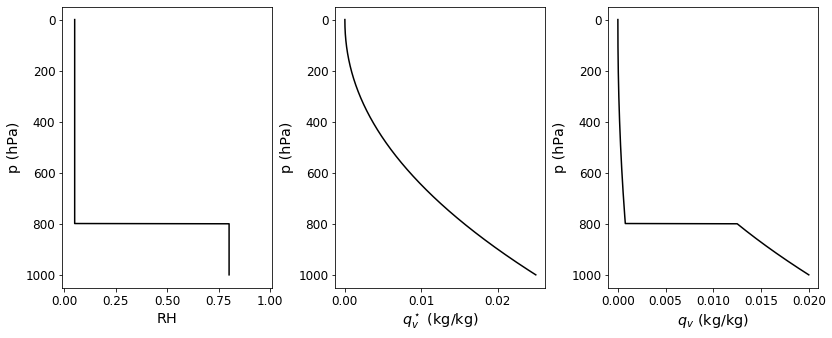

In [3]:
# pressure coordinate
pres_surf = 1000 # hPa
pres = np.linspace(0,pres_surf,1001)

# relative humidity -- step function
pres_jump = 800 # hPa
i_jump = np.where(pres >= pres_jump)[0][0]
rh_min = 0.05 # %
rh_max = 0.8 # %

# ref temperature to compute exponent alpha
temp_ref = 300 # K

# saturated specific humidity -- power function of p
qvstar_surf = 0.025 # kg/kg


# create idealized profiles
idealized = IdealizedProfiles(pres)
idealized.initRH(pres_jump,rh_max,rh_min)
idealized.computePowerExponent(temp_ref)
idealized.computeQV(qvstar_surf)


fig,axs = plt.subplots(ncols=3,figsize=(14,5))

# RH
ax = axs[0]
ax.plot(idealized.rh,idealized.pres,'k')
ax.invert_yaxis()
ax.set_xlim((-0.01,1.01))
ax.set_xlabel('RH')
2435
ax.set_ylabel('p (hPa)')

# qv_star
ax = axs[1]
ax.plot(idealized.qvstar,idealized.pres,'k')
ax.invert_yaxis()
ax.set_xlabel(r'$q_v^\star$ (kg/kg)')
ax.set_ylabel('p (hPa)')

# qv
ax = axs[2]
ax.plot(idealized.qv,idealized.pres,'k')
ax.invert_yaxis()
ax.set_xlabel(r'$q_v$ (kg/kg)')
ax.set_ylabel('p (hPa)')

plt.savefig(os.path.join(figdir,'ex_prescribed_humidity_structure.pdf'),bbox_inches='tight')

In [4]:
def waterPath(qvstar_surf,pres,pres_jump,rh_min,rh_max,alpha,i_surf=-1):
    """Water path from top of atmosphere, in mm
    
    - qv_star_surf: surface saturated specific humidity (kg/kg)
    - pres: reference pressure array (hPa)
    - pres_jump: level of RH jump (hPa)
    - rh_max: lower-tropospheric RH
    - rh_min: upper-tropospheric RH
    - alpha: power exponent
    - i_surf: index of surface layer in array (default is -1, last element)
    """
    
    hPa_to_Pa = 100
    rho_w = 1e3 # kg/m3
    m_to_mm = 1e3
    
    # init
    W = np.full(pres.shape,np.nan)
    # constant
    A = qvstar_surf/(pres[i_surf]*hPa_to_Pa)**alpha/gg/(1+alpha)
    print(A)
    # lower troposphere
    lowert = pres >= pres_jump
    W[lowert] = A*(rh_max*(pres[lowert]*hPa_to_Pa)**(alpha+1)-(rh_max-rh_min)*(pres_jump*hPa_to_Pa)**(alpha+1))
    # upper troposphere
    uppert = pres < pres_jump
    W[uppert] = A*rh_min*(pres[uppert]*hPa_to_Pa)**(alpha+1)
    
    return W/rho_w*m_to_mm

def computeBeta(pres,pres_jump,rh_min,rh_max,alpha,i_surf=-1):
    """beta exponent
    
    Arguments:
    - pres: reference pressure array (hPa)
    - pres_jump: level of RH jump (hPa)
    - rh_max: lower-tropospheric RH
    - rh_min: upper-tropospheric RH
    - alpha: power exponent
    """
    
    hPa_to_Pa = 100 

    # init
    beta = np.full(pres.shape,np.nan)
    # constant
    A = qvstar_surf/(pres[i_surf]*hPa_to_Pa)**alpha/gg/(1+alpha)
    # lower troposphere
    lowert = pres >= pres_jump
    beta[lowert] = (alpha+1)/(1 - (1-rh_min/rh_max)*(pres_jump/pres[lowert])**(alpha+1))
    # upper troposphere
    uppert = pres < pres_jump
    beta[uppert] = alpha+1
    
    return beta
    
kappa_rot = 127 # m2/kg
nu_rot = 150 # cm-1
l_rot = 56 # cm-1

def computeNuStar(W):
    """Main wavenumber emitting, from analytical fit JF2020
    
    Arguments:
    - W: water path (mm)"""
    
    return nu_rot + l_rot*np.log(kappa_rot*W)

2.4430479228950522e-14


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log


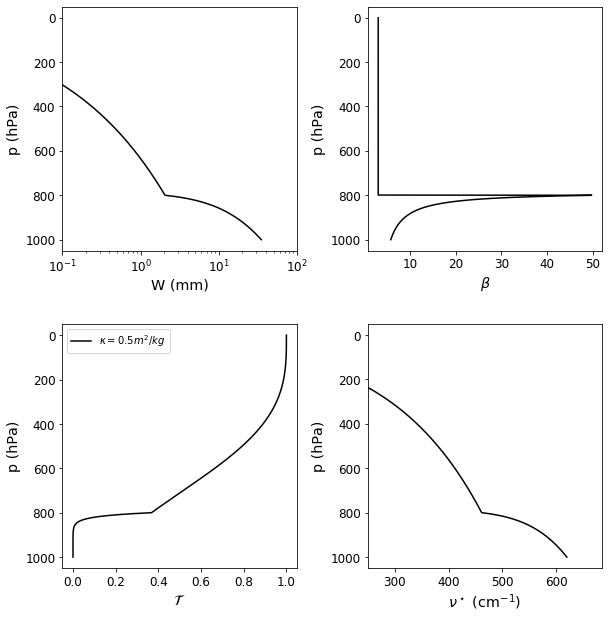

In [5]:
# water structure
idealized.computeWaterPath()
idealized.computeBeta()
idealized.computeNuStar()

# transmissivity
# kappa_ex = 0.3 # m2/kg
i_jump = np.where(pres >= pres_jump)[0][0]
kappa_ex = 1/idealized.W[i_jump]
trans = np.exp(-kappa_ex*idealized.W)

fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(10,10))

# W
ax = axs[0,0]
ax.plot(idealized.W,idealized.pres,'k')
ax.invert_yaxis()
ax.set_xscale('log')
ax.set_xlim((0.1,100.1))
ax.set_xlabel('W (mm)')
ax.set_ylabel('p (hPa)')

# beta
ax = axs[0,1]
ax.plot(idealized.beta,idealized.pres,'k')
ax.invert_yaxis()
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('p (hPa)')

# transmissivity
ax = axs[1,0]
ax.plot(trans,idealized.pres,'k',label=r'$\kappa = %2.1f m^2/kg$'%kappa_ex)
ax.invert_yaxis()
ax.set_xlabel(r'$\mathcal{T}$')
ax.set_ylabel('p (hPa)')
ax.legend()

# beta
ax = axs[1,1]
ax.plot(idealized.nu_star,idealized.pres,'k')
ax.invert_yaxis()
ax.set_xlabel(r'$\nu^\star$ (cm$^{-1}$)')
ax.set_ylabel('p (hPa)')
ax.set_xlim((249,None))

plt.savefig(os.path.join(figdir,"ex_WVP_and_nu_star.pdf"),bbox_inches='tight')

In [6]:
def computeKappa(nu):
    """Extinction coefficient kappa from wavenumber nu, 
    analytical expression from Jeevanjee&Fueglistaler (2020b)

    Arguments:
        - nu wavenumber in m-1
    Returns:
        - kappa=f(nu): extinction coefficient in m2/kg = mm-1"""

    k_rot = 127 # m2/kg
    nu_rot = 150 # cm-1
    l_rot = 56 # cm-1

    return k_rot*np.exp(-(nu/1e2-nu_rot)/l_rot) # m2/kg, or mm-1

def computePhi(kappa,W):
    """Weighting function phi(tau) = kappa * W * exp(-kappa * W)"""

    return kappa*W*np.exp(-kappa*W)

def planck(nu,temp):
    
    h = 6.626e-34 # J.s
    kB = 1.381e-23 # J.K-1
    c = 2.998e8 # m.s-1
    
    planck = 2*h*nu**3*c**2/(np.exp(h*c*nu/kB/temp)-1) # J.s-1.sr-1.m-2.cm !
    
    return planck # recode to have vector inputs and ouput matrix

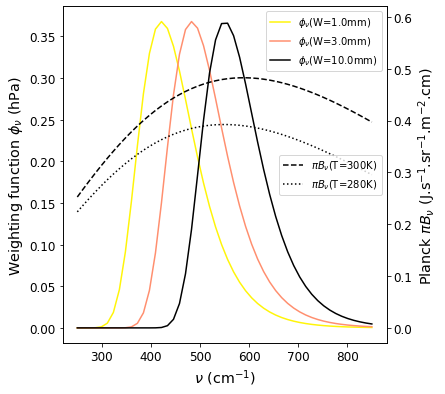

In [7]:
# weighting function in wavenumber space, at reference height
pres_star = 800 # hPa
i_p_star = np.where(pres > pres_star)[0][0]
nu = np.linspace(25000,85000) # m-1
kappa = computeKappa(nu)
# W_star = W[i_p_star]
# phi = computePhi(kappa,W_star)

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))

# phi(nu)

Ws = 1,3,10
# colors
var_col = Ws
norm = matplotlib.colors.Normalize(vmin=0,vmax=10)
# cmap = plt.cm.nipy_spectral
cmap = plt.cm.gnuplot2_r
cols = cmap(norm(var_col),bytes=True) 

for i_W in range(len(Ws)):
    
    W = Ws[i_W]
    phi = computePhi(kappa,W)
    ax.plot(nu/100,phi,c=cols[i_W][:3]/255,label=r"$\phi_\nu$(W=%2.1fmm)"%W)
    
ax.set_xlabel(r'$\nu$ (cm$^{-1}$)')
ax.set_ylabel(r'Weighting function $\phi_\nu$ (hPa)')
ax.legend(loc='upper right')


ax_B = ax.twinx()

B_nu_300 = planck(nu,300)*1e2 # W.sr-1.m-2.cm 
ax_B.plot(nu/100,pi*B_nu_300,'k--',label=r'$\pi B_\nu$(T=300K)')

B_nu_280 = planck(nu,280)*1e2 # W.sr-1.m-2.cm 
ax_B.plot(nu/100,pi*B_nu_280,'k:',label=r'$\pi B_\nu$(T=280K)')

ax_B.legend(loc='right')
ax_B.set_ylabel(r'Planck $\pi B_\nu$ (J.s$^{-1}$.sr$^{-1}$.m$^{-2}$.cm)')

# align zero of both graphs
ax_lim = ax.axes.get_ylim()
ax_frac_below_zero = -ax_lim[0]/(ax_lim[1]-ax_lim[0])
ax_B_range = 0.65
ax_B.set_ylim((-ax_frac_below_zero*ax_B_range,(1-ax_frac_below_zero)*ax_B_range))

plt.savefig(os.path.join(figdir,"spectral_width_B_and_phi.pdf"),bbox_inches='tight')

## Spectral width

$$ \Delta \nu^\star \approx l_{rot}\ln\left(\frac{\varphi_s}{\varphi_t}\right) \quad \quad ?$$

In [8]:
l_rot*log(rh_max/rh_min), l_rot*log(1+e)

(155.26496844542774, 73.54265450102048)

$$ \Delta \nu^\star = \frac{d \nu^\star}{dp} \Delta p = l_{rot} (1+\alpha)\frac{\varphi_s}{\varphi_t}\frac{\Delta p}{p_\perp} \quad \quad ?$$

In [9]:
dp = np.diff(pres)[0]
print(l_rot*(1+idealized.alpha)*rh_max/rh_min*dp/pres_jump)

3.4778783536522053


In [10]:
rh_max/rh_min, pres_jump

(16.0, 800)

# Compare with radiative transfer code

In [11]:
from matrixoperators import *
from radiativefeatures import *
from radiativescaling import *

## Automate idealized profiles

In [12]:
class IdealizedProfiles():
    
    def __init__(self,pres,\
                    temp_ref,\
                    kappa_rot = 127,\
                    nu_rot = 150,\
                    l_rot = 56,\
                    i_surf=-1):
        """Constructor -- initalize pressure coordinate.
        
        Arguments:
        - p_values: reference pressure array (hPa)
        - temp_ref: reference temperature (K)
        - kappa_rot, default = 127 # m2/kg
        - nu_rot, default = 150 # cm-1
        - l_rot, default = 56 # cm-1
        - i_surf: index of surface layer in array (default is -1, last element)
        """
        
        self.pres = pres
        self.temp_ref = temp_ref
        self.i_surf = i_surf
        self.z = R_d*temp_ref/gg*np.log(self.pres[i_surf]/self.pres)
        self.kappa_rot = kappa_rot
        self.nu_rot = nu_rot
        self.l_rot = l_rot
    
    
    def initRH(self,pres_jump,rh_max,rh_min):
        """Generate an RH profile as a step function

        Arguments:
        - pres_jump: level of RH jump (hPa)
        - rh_max: lower-tropospheric RH
        - rh_min: upper-tropospheric RH
        """    

        # store input parameters
        self.pres_jump = pres_jump
        self.rh_max = rh_max
        self.rh_min = rh_min
        
        # init
        rh_values = np.full(self.pres.shape,np.nan)
        # masks
        lowert = self.pres >= pres_jump
        uppert = self.pres < pres_jump
        # assign
        rh_values[uppert] = rh_min
        rh_values[lowert] = rh_max

        self.rh = rh_values
    
    def computePowerExponent(self):
        """Approximation of exponent alpha

        Arguments:
        - temp: (K)"""

        Gamma = 6.5e-3 # K/m   

        self.alpha = L_v*Gamma/self.temp_ref/gg*R_d/R_v - 1
        
    def computeQV(self,qvstar_surf):
        """Idealized qv_star profile as a power function of pressure

        Arguments:
        - qvstar_surf: surface saturated specific humidity (kg/kg)"""

        self.qvstar_surf = qvstar_surf
        # qv_star
        self.qvstar =  qvstar_surf*np.power((self.pres/self.pres[self.i_surf]),self.alpha)
        # qv
        self.qv = self.rh * self.qvstar

    def computeWaterPath(self):
        """Water path from top of atmosphere, in mm
        """

        hPa_to_Pa = 100
        rho_w = 1e3 # kg/m3
        m_to_mm = 1e3

        # init
        W = np.full(self.pres.shape,np.nan)
        # constant
        A = self.qvstar_surf/(self.pres[self.i_surf]*hPa_to_Pa)**self.alpha/gg/(1+self.alpha)
        print(A)
        # lower troposphere
        lowert = self.pres >= self.pres_jump
        W[lowert] = A*(self.rh_max*(self.pres[lowert]*hPa_to_Pa)**(self.alpha+1)-\
                       (self.rh_max-self.rh_min)*(self.pres_jump*hPa_to_Pa)**(self.alpha+1))
        # upper troposphere
        uppert = self.pres < self.pres_jump
        W[uppert] = A*self.rh_min*(self.pres[uppert]*hPa_to_Pa)**(self.alpha+1)

        self.W = W/rho_w*m_to_mm

    def computeBeta(self):
        """beta exponent
        """

        hPa_to_Pa = 100 

        # init
        beta = np.full(self.pres.shape,np.nan)
        # constant
        A = self.qvstar_surf/(self.pres[self.i_surf]*hPa_to_Pa)**self.alpha/gg/(1+self.alpha)
        # lower troposphere
        lowert = self.pres >= self.pres_jump
        beta[lowert] = (self.alpha+1)/(1 - (1-self.rh_min/self.rh_max)*(self.pres_jump/self.pres[lowert])**(self.alpha+1))
        # upper troposphere
        uppert = self.pres < self.pres_jump
        beta[uppert] = self.alpha+1

        self.beta = beta

    def computeNuStar(self):
        """Main wavenumber emitting, from analytical fit JF2020"""

        self.nu_star = self.nu_rot + self.l_rot*np.log(self.kappa_rot*self.W)
        
#     ###--- integral scaling
    
#     def computeSpectralIntegral(self):
#         """Spectral integral \int pi B(T(p)) phi(tau(p)) d\nu"""

#         # wavenumber structure
#         self.nu_array = np.linspace(20000,80000) # m-1 (that range works well, to be adapted for other contexts)
#         self.dnu_array = np.diff(self.nu_array) # m-1
#         N_nu = len(self.nu_array)
#         N_s = self.pres.shape[0]
#         N_z = self.pres.shape[1]
        
#         # stores int_nu(pi*B*phi) in dimensions (N_s,N_z)
#         self.spectral_integral = np.full((N_s,N_z),np.nan)
        
#         for i_s in range(N_s):
            
#             # stores pi*B*phi*d_nu in (N_nu,N_s) at i_s, before integration
#             integrand_nu = np.full((N_nu-1,N_z),np.nan)
            
#             for i_nu in range(N_nu-1):
                
#                 nu_inv_m = self.nu_array[i_nu]
#                 # Planck
#                 B_nu = self.planck(nu_inv_m,self.temp[i_s]) # W.sr-1.m-2.m
#                 # phi
#                 W_s = self.rad_features.wp_z[i_s] # mm
#                 kappa_nu = self.kappa(nu_inv_m) # m2/kg, or mm-1
#                 phi_nu = self.phi(kappa_nu,W_s)
#                 # product
#                 integrand_nu[i_nu] = pi*B_nu*phi_nu*self.dnu_array[i_nu]
#                 # print(integrand_nu[i_nu])
            
#             self.spectral_integral[i_s] = np.nansum(integrand_nu,axis=0)
    
#     #-- scaling for radiative profile
    
#     def computeScalingProfileWithIntegral(self):
#         """Analytical scaling including the spectral integral:
#             H(p) ≈ - g/c_p * beta(p)/p * \int_\nu \pi B_\nu(T(p)) \phi_nu(p) d\nu
            
#         Stores the result."""
        
#         day_to_seconds = 86400
        
#         self.scaling_profile = -self.g/self.c_p*(self.beta/self.pres)*self.spectral_integral*day_to_seconds

    
    
    ###--- 

    def computeDeltaNu(self):
        """Stephan's delta_nu_star"""
        
        dp = np.diff(self.pres)[0]
        self.delta_nu_star = self.l_rot*(1+self.alpha)*self.rh_max/self.rh_min*dp/self.pres_jump
        

In [13]:
rh_min_all =  0.05,  0.1,  0.2,  0.05, 0.05, 0.05, 0.05
rh_max_all =   0.8,  0.8,  0.8,   0.7,  0.9,  0.8,  0.8
pres_jump_all = 80000,80000,80000, 80000,80000,90000,70000 # Pa
Nprof = len(rh_max_all)

path = '/Users/bfildier/Code/analyses/EUREC4A/EUREC4A_rad_profiles/output/rad_profiles/idealized_profiles'
rad_file = 'rad_profiles_stepRH.nc'

radprf_stepRH = xr.open_dataset(os.path.join(path,rad_file))

In [14]:
print("Apply idealized calculation to all parameter sets")

hPa_to_Pa = 1e-2

# pressure coordinate
pres_surf = 1000 # hPa
pres = np.linspace(0,pres_surf,1001)

# ref temperature to compute exponent alpha
temp_ref = 300 # K

# saturated specific humidity -- power function of p
qvstar_surf = 0.025 # kg/kg

# initalize storage
all_idealized = []

# calculation for each profile
for i_id in range(Nprof):
    
    # initialize idealized profile
    idealized = IdealizedProfiles(pres,temp_ref)
        
    # relative humidity -- step function
    pres_jump = pres_jump_all[i_id]*hPa_to_Pa # hPa
    rh_min = rh_min_all[i_id] # %
    rh_max = rh_max_all[i_id] # %
    
    # water vapor structure
    idealized.initRH(pres_jump,rh_max,rh_min)
    idealized.computePowerExponent()
    idealized.computeQV(qvstar_surf)

    idealized.computeWaterPath()
    idealized.computeBeta()
    
    # spectral things
    idealized.computeNuStar()
    
    # save
    all_idealized.append(idealized)

Apply idealized calculation to all parameter sets
2.4430479228950522e-14
2.4430479228950522e-14
2.4430479228950522e-14
2.4430479228950522e-14
2.4430479228950522e-14
2.4430479228950522e-14
2.4430479228950522e-14


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in log


show analytical beta and rrtmgp qrad


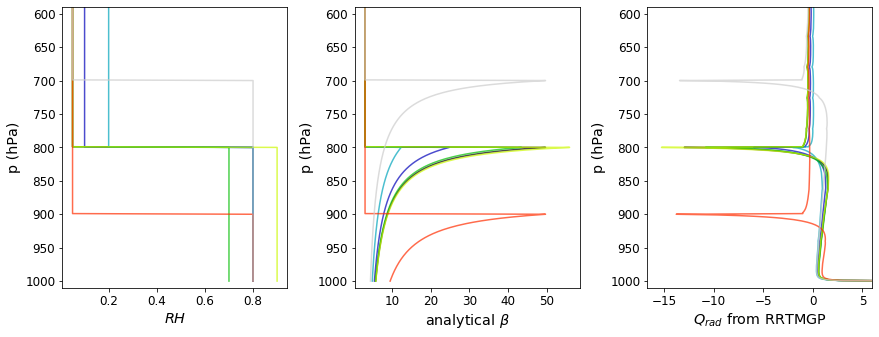

In [15]:
print("show analytical beta and rrtmgp qrad")

# colors
var_col = np.arange(Nprof)
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col)) 


# --- Figure ---
fig,axs = plt.subplots(ncols=3,figsize=(15,5))

pres = all_idealized[0].pres

# shape of RH
ax = axs[0]

for i_id in range(Nprof):
    rh = all_idealized[i_id].rh
    ax.plot(rh,pres,'-',c=cols[i_id],alpha=0.7)
    
ax.set_xlabel(r'$RH$')

# analytical beta
ax = axs[1]

for i_id in range(Nprof):
    beta = all_idealized[i_id].beta
    ax.plot(beta,pres,'-',c=cols[i_id],alpha=0.7)
    
ax.set_xlabel(r'analytical $\beta$')
    
# rrtmgp qrad
ax = axs[2]
for i_id in range(Nprof):
    qrad = radprf_stepRH.q_rad[i_id]
    ax.plot(qrad,radprf_stepRH.play/100,'-',c=cols[i_id],alpha=0.7)
    
ax.set_xlim((None,6))
ax.set_xlabel(r'$Q_{rad}$ from RRTMGP')

for ax in axs:
    ax.set_ylim((590,1010))
    ax.invert_yaxis()
    ax.set_ylabel('p (hPa)')
    
plt.savefig(os.path.join(figdir,"ex_profiles_comparison_with_RRTMGP.pdf"),bbox_inches='tight')

## Compare features with integral scaling

In [16]:
## FIX BELOW TO COMPARE BETA@peak AND QRAD@peak

data = radprf_stepRH

mo = MatrixOperators()


play = data.play.data/1e2 # hPa
# play_2D = np.hstack([play]*Nprof)
zlay = R_d*300/gg*np.log(play[0]/play)/1e3

qv = data.h2o.data # kg(w)/kg(a)
tlay = data.tlay.data # K
# qv = np.stack([0.02*np.power(play/play[0],3.)]*2)
# tlay = np.ones(data.h2o.shape)[:2]


dim_z = 1

##-- compute radiative features
print("- compute radiative features")

# Initialize
# f = FeaturesFromXarray()
f = Features(play,zlay)
# Find peaks in net Q_rad
f.computePeaks(data.q_rad.data,which='net')
# Find peaks in LW Q_rad
f.computePeaks(data.q_rad_lw.data,which='lw')
# Find peaks in SW Q_rad
f.computePeaks(data.q_rad_sw.data,which='sw')
# Compute PW
f.computePW(qv,tlay,tlay,zlay)
# Compute water path above z
f.computeWPaboveZ(qv,play,z_axis=dim_z)
# Compute PW truncated at qrad peak
f.computePW(qv,tlay,play,zlay,i_z_max=f.i_net_peak,attr_name='pw_below_net_qrad_peak')
# Compute PW truncated at lw qrad peak
f.computePW(qv,tlay,play,zlay,i_z_max=f.i_lw_peak,attr_name='pw_below_lw_qrad_peak')


- compute radiative features


In [17]:
play_allprofs = np.vstack([play]*Nprof)

# Initialize
rs = RadiativeScaling(play_allprofs,tlay,qv,f)
# Compute all terms of radiative scaling (to see detail, look at the method itself)
rs.computeScaling()

3.0772235725762545 0.0013265404165629777
0.0013265404165629777
2.9474140256366974 0.0013235473559861266
0.0013235473559861266
5.125420193206974 0.0013486405552182357
0.0013486405552182357
4.9956106462674175 0.001347069038223941
0.001347069038223941
9.221813434468414 0.0013619371209437204
0.0013619371209437204
9.092003887528858 0.001361018036579409
0.001361018036579409
2.9485952035830625 0.0013242265319752167
0.0013242265319752167
2.83501185001095 0.0013213794483025864
0.0013213794483025864
3.2058519415694464 0.0013286911373372103
0.0013286911373372103
3.0598162012624446 0.001325576891366388
0.001325576891366388
4.270555658944993 0.0014134215663233122
0.0014134215663233122
4.104553478832371 0.0014107188089728336
0.0014107188089728336
2.0322270095064887 0.0012335579467838036
0.0012335579467838036
2.0322270095064887 0.0012335579467838036
0.0012335579467838036
0.004
0.004
0.004
0.004
0.004
0.004
0.004
0.004
0.004
0.004
0.004
0.004
0.004
0.004


/Users/bfildier/Code/analyses/EUREC4A/EUREC4A_organization/functions/radiativescaling.py:146: RuntimeWarning: divide by zero encountered in log
  self.ln_W = np.log(self.rad_features.wp_z)
/Users/bfildier/Code/analyses/EUREC4A/EUREC4A_organization/functions/matrixoperators.py:54: RuntimeWarning: invalid value encountered in subtract
  da = np.take(a,range(1,Nx),axis=axis)-np.take(a,range(0,Nx-1),axis=axis)


In [18]:
print(f.lw_peaks.qrad_lw_peak)
print(rs.scaling_magnitude_lw_peak)
print(f.scaling_profile_peak)
print(f.pres_beta_peak)
print(f.pres_lw_peak)
print(rs.rad_features.scaling_profile_peaks.pres_scaling_profile_peak)
print(rs)

<xarray.DataArray 'qrad_lw_peak' (PW: 7)>
array([-15.67944982, -10.18265566,  -5.97048955, -14.06737326,
       -17.23625793, -16.03687494, -15.46084286])
Dimensions without coordinates: PW
[-413.4590166  -240.44358013 -132.10599152 -374.45074359 -450.19305931
 -378.17126097 -456.31030151]
[-1027.85548228  -614.76003828  -342.75335964  -932.03608629
 -1117.78525899 -1019.18532905 -1038.73488582]
[808. 808. 808. 808. 808. 908. 707.]
[807. 807. 807. 807. 807. 907. 707.]
<xarray.DataArray 'pres_scaling_profile_peak' (PW: 7)>
array([808., 808., 808., 808., 808., 908., 708.])
Dimensions without coordinates: PW
B_star_beta_peak : <class 'numpy.ndarray'>
B_star_beta_peak_B040 : <class 'numpy.ndarray'>
B_star_lw_peak : <class 'numpy.ndarray'>
B_star_lw_peak_B040 : <class 'numpy.ndarray'>
beta : <class 'numpy.ndarray'>
beta_over_p : <class 'numpy.ndarray'>
c = 299800000.0
c_p = 1000
dnu_array : <class 'numpy.ndarray'>
g = 9.81
h = 6.626e-34
kB = 1.381e-23
kappa_star_beta_peak : <class 'numpy.nd

show analytical beta and rrtmgp qrad


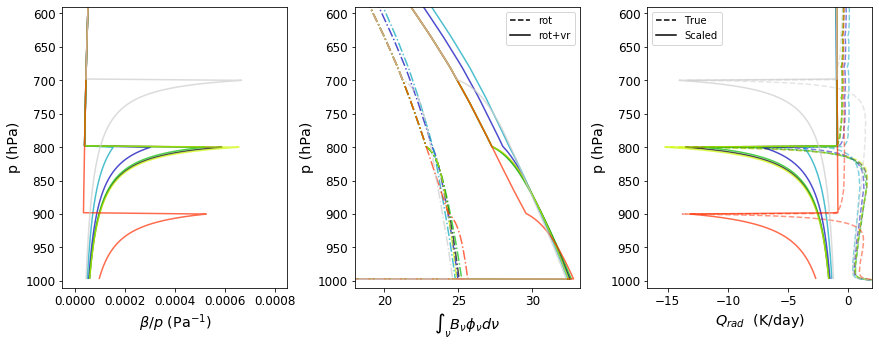

In [18]:
print("show analytical beta and rrtmgp qrad")

from matplotlib.lines import Line2D

day_to_s = 86400
hPa_to_Pa = 1e2

# colors
var_col = np.arange(Nprof)
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col)) 


# --- Figure --- 

fig,axs = plt.subplots(ncols=3,figsize=(15,5))

pres = all_idealized[0].pres

#-- shape of beta after smoothing
ax = axs[0]

for i_id in range(Nprof):
    beta_over_p = rs.beta[i_id]/pres[:-1]/hPa_to_Pa
    ax.plot(beta_over_p,pres[:-1],'-',c=cols[i_id],alpha=0.7)
    
ax.set_xlabel(r'$\beta/p$ (Pa$^{-1}$)')
ax.set_xlim((-0.00005,0.00085))
ax.invert_yaxis()

#-- spectral integral
ax = axs[1]

for i_id in range(Nprof):
    # both spectral bands
    spec_int = rs.spectral_integral_rot[i_id] + rs.spectral_integral_vr[i_id]
    ax.plot(spec_int,pres[:-1],'-',c=cols[i_id],alpha=0.7)
    # rotational band
    spec_int = rs.spectral_integral_rot[i_id]
    ax.plot(spec_int,pres[:-1],'-.',c=cols[i_id],alpha=0.7)

ax.set_xlabel(r'$\int_\nu B_\nu \phi_\nu d\nu$')
ax.set_xlim((18,33.2))

#-- legend
legend_elements = [Line2D([0], [0], color='k', linestyle='--', label='rot'),
                   Line2D([0], [0], color='k', linestyle='-', label='rot+vr')]
ax.legend(handles=legend_elements, loc='upper right')
    
#-- scaled profile
ax = axs[2]
# true
for i_id in range(Nprof):
    qrad = radprf_stepRH.q_rad[i_id]
    ax.plot(qrad,radprf_stepRH.play/100,c=cols[i_id],linestyle='--',alpha=0.5)
# scaled
for i_id in range(Nprof):
    beta_over_p = rs.beta[i_id]/pres[:-1]/hPa_to_Pa
    i_peak = rs.rad_features.i_lw_peak[i_id]
    # both spectral bands
    spec_int = rs.spectral_integral_rot[i_id] + rs.spectral_integral_vr[i_id]
    qrad_est = -gg/c_pd*beta_over_p*spec_int*day_to_s
    ax.plot(qrad_est,pres[:-1],'-',c=cols[i_id],alpha=0.7)

    
ax.set_xlabel(r'$Q_{rad}$  (K/day)')
ax.set_xlim((None,2))

for ax in axs:
    ax.set_ylim((590,1010))
    ax.invert_yaxis()
    ax.set_ylabel('p (hPa)')
    
#-- legend
legend_elements = [Line2D([0], [0], color='k', linestyle='--', label='True'),
                   Line2D([0], [0], color='k', linestyle='-', label='Scaled')]
ax.legend(handles=legend_elements, loc='upper left')
    
plt.savefig(os.path.join(figdir,"ex_QRAD_profile_comparison_with_RRTMGP.pdf"),bbox_inches='tight')

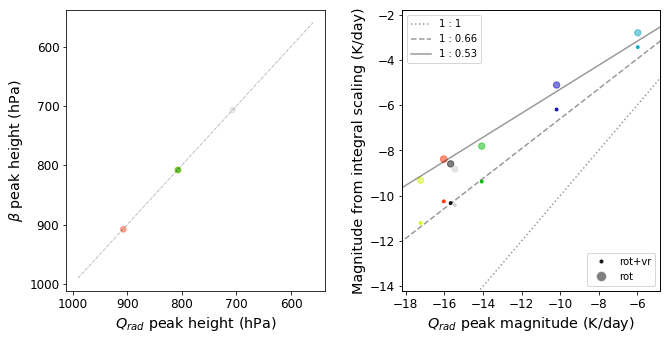

In [76]:
hPa_to_Pa = 1e2
day_to_s = 86400
m_to_cm = 1e2

# colors
var_col = np.arange(Nprof)
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col)) 

# --- Figure ---

fig,axs = plt.subplots(ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.3)

#--  (a) peak height, using the simpler approximation for peak heights, showing binned profiles each day
ax = axs[0]


# proxy peak heights
pres_beta_peak = rs.rad_features.beta_peaks.pres_beta_peak
pres_beta_over_p_peak = rs.rad_features.beta_over_p_peaks.pres_beta_over_p_peak
pres_scaling_profile_peak = rs.rad_features.scaling_profile_peaks.pres_scaling_profile_peak
# pres_proxy_peak = pres_beta_over_p_peak
pres_proxy_peak = pres_beta_peak
# qrad peak height
pres_qrad_peak = rs.rad_features.lw_peaks.pres_lw_peak

s = 2*np.absolute(rs.rad_features.lw_peaks.qrad_lw_peak)

# 1:1 line
ax.plot([990,560],[990,560],'k-.',linewidth=0.5,alpha=0.5)
# peaks
ax.scatter(pres_qrad_peak,pres_proxy_peak,c=cols,s=s,alpha=0.4)

ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel(r'$Q_{rad}$ peak height (hPa)')
ax.set_ylabel(r'$\beta$ peak height (hPa)')


#-- (b) peak magnitude, using the full integral approximation for peak magnitudes
ax = axs[1]

H_peak_all = {}
qrad_peak_all = {}

#- approximated peak
# H_peak = rad_scaling_all[day].scaling_magnitude_lw_peak*1e8
Ns = rs.rad_features.pw.size
H_peak = np.full(Ns,np.nan)
H_peak_rot = np.full(Ns,np.nan)
for i_s in range(Ns):
    # i_z = rad_scaling_all[day].rad_features.scaling_profile_peaks.i_scaling_profile_peak[i_s]
#     H_peak[i_s] = rs.scaling_magnitude_lw_peak[i_s]/hPa_to_Pa

    # rotational band only
    beta_over_p = rs.beta[i_s]/pres[:-1]/hPa_to_Pa
    spec_int = rs.spectral_integral_rot[i_s]
    qrad_est = -gg/c_pd*beta_over_p*spec_int*day_to_s
    i_peak = rs.rad_features.i_lw_peak[i_s]
    H_peak_rot[i_s] = qrad_est[i_peak]

    # rotational and v-r bands
    beta_over_p = rs.beta[i_s]/pres[:-1]/hPa_to_Pa
    spec_int = rs.spectral_integral_rot[i_s] + rs.spectral_integral_vr[i_s]
    qrad_est = -gg/c_pd*beta_over_p*spec_int*day_to_s
    i_peak = rs.rad_features.i_lw_peak[i_s]
    H_peak[i_s] = qrad_est[i_peak]

#- true peak
qrad_peak = rs.rad_features.lw_peaks.qrad_lw_peak

s_rot = 0.05*np.absolute(rs.rad_features.lw_peaks.pres_lw_peak)
s = 0.01*np.absolute(rs.rad_features.lw_peaks.pres_lw_peak)

# plot
ax.scatter(qrad_peak,H_peak,c=cols,s=s,alpha=0.9)
ax.scatter(qrad_peak,H_peak_rot,c=cols,s=s_rot,alpha=0.5)
# lines
ax_lines = ax.twinx()
x_ex = np.array([-20,0])
ax_lines.plot(x_ex,x_ex,'k:',alpha=0.4,label='1 : 1')
a_rot = 0.66
a_full = 0.53
ax_lines.plot(x_ex,a_rot*x_ex,'k--',alpha=0.4,label='1 : %1.2f'%a_rot)
ax_lines.plot(x_ex,a_full*x_ex,'k-',alpha=0.4,label='1 : %1.2f'%a_full)
ax_lines.legend(loc='upper left')

# axes labels and ranges
ax.set_xlabel(r'$Q_{rad}$ peak magnitude (K/day)')
ax.set_ylabel('Magnitude from integral scaling (K/day)')
ax.set_ylim((-14.2,-1.8))
ax_lines.set_ylim((-14.2,-1.8))
ax.set_xlim((-18.2,-4.8))
ax_lines.get_yaxis().set_ticks([])

#- legend
lgd = [Line2D([0], [0],  marker='o',color='w',markerfacecolor='k',alpha=0.9, label='rot+vr'),
                   Line2D([0], [0],  marker='o',color='w',markerfacecolor='k',alpha=0.5, label='rot')]
# adjust sizes manually ----- would need to find a better way :/
lgd[0].set_ms(5)
lgd[1].set_ms(10)

lgd = ax.legend(handles=lgd, loc='lower right')


plt.savefig(os.path.join(figdir,"ex_QRAD_peaks_comparison_with_RRTMGP.pdf"),bbox_inches='tight')

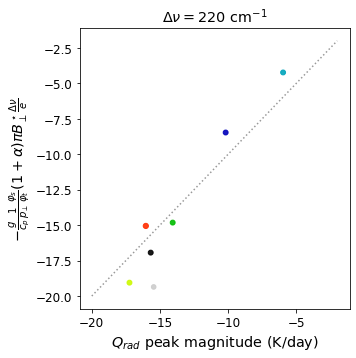

In [80]:
hPa_to_Pa = 1e2
day_to_s = 86400
m_to_cm = 1e2

# colors
var_col = np.arange(Nprof)
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col)) 

# --- Figure ---

fig,ax = plt.subplots(ncols=1,figsize=(5,5))
plt.subplots_adjust(wspace=0.3)

#- approximated peak
Ns = rs.rad_features.pw.size
H_peak = np.full(Ns,np.nan)
for i_s in range(Ns):
    # i_z = rad_scaling_all[day].rad_features.scaling_profile_peaks.i_scaling_profile_peak[i_s]
#     H_peak[i_s] = rs.scaling_magnitude_lw_peak[i_s]/hPa_to_Pa

    # rotational band only
    p_jump = pres_jump_all[i_s]
    rh_max = rh_max_all[i_s]
    rh_min = rh_min_all[i_s]
    alpha = idealized.alpha
    piB_star = 0.4
    delta_nu = 220 # cm-1 150cm-1
    qrad_est = -gg/c_pd / (p_jump*hPa_to_Pa) *(1+alpha)* (rh_max/rh_min)*piB_star*delta_nu*m_to_cm/e*day_to_s
    H_peak[i_s] = qrad_est

#- true peak
qrad_peak = rs.rad_features.lw_peaks.qrad_lw_peak

s = 0.03*np.absolute(rs.rad_features.lw_peaks.pres_lw_peak)

# plot
ax.scatter(qrad_peak,H_peak,c=cols,s=s,alpha=0.9)
x_ex = np.array([-20,-2])
ax.plot(x_ex,x_ex,'k:',alpha=0.4,label='1 : 1')

# axes labels and ranges
ax.set_xlabel(r'$Q_{rad}$ peak magnitude (K/day)')
ax.set_ylabel(r'$-\frac{g}{c_p} \frac{1}{p_\perp} \frac{\varphi_s}{\varphi_t} (1+\alpha)\pi B^\star_\perp \frac{\Delta\nu}{e}$')
ax.set_title(r'$\Delta\nu =$%3.0f cm$^{-1}$'%delta_nu)

plt.savefig(os.path.join(figdir,"ex_QRAD_peaks_comparison_simpler_with_RRTMGP.pdf"),bbox_inches='tight')

In [ ]:
# hPa_to_Pa = 1e2
# day_to_s = 86400
# m_to_cm = 1e2

# # colors
# var_col = np.arange(Nprof)
# norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
# cmap = plt.cm.nipy_spectral
# cols = cmap(norm(var_col)) 

# # --- Figure ---

# fig,ax = plt.subplots(ncols=1,figsize=(5,5))
# plt.subplots_adjust(wspace=0.3)

# #- approximated peak
# Ns = rs.rad_features.pw.size
# H_peak = np.full(Ns,np.nan)
# for i_s in range(Ns):
#     # i_z = rad_scaling_all[day].rad_features.scaling_profile_peaks.i_scaling_profile_peak[i_s]
# #     H_peak[i_s] = rs.scaling_magnitude_lw_peak[i_s]/hPa_to_Pa

#     # rotational band only
#     p_jump = pres_jump_all[i_s]
#     rh_max = rh_max_all[i_s]
#     rh_min = rh_min_all[i_s]
#     alpha = idealized.alpha
#     piB_star = 0.4
#     delta_nu = 220 # cm-1 150cm-1
#     qrad_est = -gg/c_pd / (p_jump*hPa_to_Pa) *(1+alpha)* (rh_max/rh_min)*piB_star*delta_nu*m_to_cm/e*day_to_s
#     H_peak[i_s] = qrad_est

# #- true peak
# qrad_peak = rs.rad_features.lw_peaks.qrad_lw_peak

# s = 0.03*np.absolute(rs.rad_features.lw_peaks.pres_lw_peak)

# # plot
# ax.scatter(qrad_peak,H_peak,c=cols,s=s,alpha=0.9)
# x_ex = np.array([-20,-2])
# ax.plot(x_ex,x_ex,'k:',alpha=0.4,label='1 : 1')

# # axes labels and ranges
# ax.set_xlabel(r'$Q_{rad}$ peak magnitude (K/day)')
# ax.set_ylabel(r'$-\frac{g}{c_p} \frac{1}{p_\perp} \frac{\varphi_s}{\varphi_t} (1+\alpha)\pi B^\star_\perp \frac{\Delta\nu}{e}$')
# ax.set_title(r'$\Delta\nu =$%3.0f cm$^{-1}$'%delta_nu)

# plt.savefig(os.path.join(figdir,"ex_QRAD_peaks_comparison_simpler_ln_rhratio_with_RRTMGP.pdf"),bbox_inches='tight')

## Compare spectral widths

Investigate the simplification

$$ \mathscr{H}^\star \sim - \frac{g}{c_p}\frac{\beta(p^\star)}{p^\star} \pi B_{\nu^\star}(T^\star) \frac{\Delta \nu}{e} $$

with 

$$ \Delta \nu \approx \frac{d \nu^\star}{dp} \Delta p = l_{rot} (1+\alpha)\frac{\varphi_s}{\varphi_t}\frac{\Delta p}{p_\perp} $$

Compare effective spectral width

$$ \Delta \nu = \int B_\nu \phi_\nu d\nu \times \frac{e}{B_{\nu^\star}} $$

with scaling:

$$ \Delta \nu \sim l_{rot} \ln \left( \frac{\varphi_s}{\varphi_t} \right) $$

0.41580466502442104
0.4231942194362601
0.4275764265121076
0.41512359673919386
0.41644226236850396
0.44319038465499966
0.3875336583393306


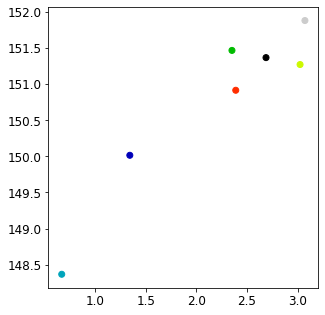

In [48]:
## Show H* / (-g/c_p beta*/p* pi B*) vs. phi_s/phi_t

m_to_cm = 1e2

# colors
var_col = np.arange(Nprof)
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col)) 

# --- Figure ---

fig,ax = plt.subplots(ncols=1,figsize=(5,5))

Ns = rs.rad_features.pw.size
spec_int_div_B = np.full((Ns,),np.nan)
rh_ratio = np.full((Ns,),np.nan)
rh_diff = np.full((Ns,),np.nan)
for i_s in range(Ns):

    # rotational band only
    i_peak = rs.rad_features.i_lw_peak[i_s]
    B_star = (rs.B_star_lw_peak*pi*m_to_cm)[i_s]
    spec_int = rs.spectral_integral_rot[i_s][i_peak]
    print(B_star)
    spec_int_div_B[i_s] = spec_int/B_star
    rh_ratio[i_s] = rh_max_all[i_s]/rh_min_all[i_s]
    rh_diff[i_s] = rh_max_all[i_s]-rh_min_all[i_s]

delta_nu_phi = l_rot*np.log(1+e)
delta_nu_star = l_rot*3*(rh_ratio)/np.array(pres_jump_all)*80
    
ax.scatter(delta_nu_star,spec_int_div_B*e,c=cols)

In [52]:
2*l_rot*np.log(1+e), 2*l_rot*log(4)

(147.08530900204096, 155.26496844542774)

In [128]:
print(rs.B_star_lw_peak_B040*m_to_cm)

for i_s in range(Ns):

    i_star = rs.rad_features.lw_peaks.i_lw_peak[i_s]
    temp_star = rs.temp[i_s,i_star]
    W_star = rs.rad_features.wp_z[i_s,i_star]
    kappa_star = 1/W_star
    nu_star = rs.nu(kappa_star)
    B_star = rs.planck(nu_star, temp_star)

    print(pi*B_star)

rs.computeScalingPeakMagnitude()
print(rs.B_star_lw_peak*pi)

[0.4 0.4 0.4 0.4 0.4 0.4 0.4]
0.00415804665024421
0.004231942194362601
0.004275764265121076
0.004151235967391939
0.0041644226236850395
0.004431903846549997
0.0038753365833933064
[0.00416745 0.00416745 0.00416745 0.00416745 0.00416745 0.00416745
 0.00416745]
